In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
data_dir = Path("/content/drive/MyDrive/Colab Notebooks/Energy Forecasting/data")

In [3]:
data = pd.read_csv(data_dir / "demand.csv")
demand_data = data[['datetime', 'Demand (MW)']].copy()
demand_data.head()

,datetime,Demand (MW)
0,2020-01-01 00:00:00,445.8
1,2020-01-01 01:00:00,424.5
2,2020-01-01 02:00:00,423.5
3,2020-01-01 03:00:00,418.8
4,2020-01-01 04:00:00,414.8


In [4]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27723 entries, 0 to 27722
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   datetime     27723 non-null  object 
 1   Demand (MW)  27555 non-null  float64
dtypes: float64(1), object(1)
memory usage: 433.3+ KB


In [5]:
demand_data["datetime"] = pd.to_datetime(demand_data["datetime"])
# convert the datetime into the hourly period
demand_data["datetime"] = demand_data["datetime"].dt.to_period("H")

In [6]:
demand_data = demand_data.set_index("datetime")

In [7]:
display(demand_data.head())
display(demand_data.tail())

,Demand (MW)
datetime,
2020-01-01 00:00,445.8
2020-01-01 01:00,424.5
2020-01-01 02:00,423.5
2020-01-01 03:00,418.8
2020-01-01 04:00,414.8


,Demand (MW)
datetime,
2023-02-28 19:00,NaN
2023-02-28 20:00,NaN
2023-02-28 21:00,NaN
2023-02-28 22:00,NaN
2023-02-28 23:00,NaN


In [8]:
train_data = demand_data.dropna().copy()
test_data = demand_data[demand_data.isnull().any(axis=1)].copy()

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 27555 entries, 2020-01-01 00:00 to 2023-02-21 23:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand (MW)  27555 non-null  float64
dtypes: float64(1)
memory usage: 430.5 KB


In [10]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 168 entries, 2023-02-22 00:00 to 2023-02-28 23:00
Freq: H
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Demand (MW)  0 non-null      float64
dtypes: float64(1)
memory usage: 2.6 KB


**We have train data and we have to predict for next 7 days demand forecast i.e 24*7=168 entries**

In [11]:
train_data.head()

,Demand (MW)
datetime,
2020-01-01 00:00,445.8
2020-01-01 01:00,424.5
2020-01-01 02:00,423.5
2020-01-01 03:00,418.8
2020-01-01 04:00,414.8


### let's observe seasonal decomposition, ACF and PACF plots

In [12]:
type(train_data.index.freq)

pandas._libs.tslibs.offsets.Hour

In [13]:
train_data["Demand (MW)"].head()

datetime
2020-01-01 00:00    445.8
2020-01-01 01:00    424.5
2020-01-01 02:00    423.5
2020-01-01 03:00    418.8
2020-01-01 04:00    414.8
Freq: H, Name: Demand (MW), dtype: float64

In [14]:
X_tmp = train_data.reset_index()["Demand (MW)"]
X_tmp.head()

0    445.8
1    424.5
2    423.5
3    418.8
4    414.8
Name: Demand (MW), dtype: float64

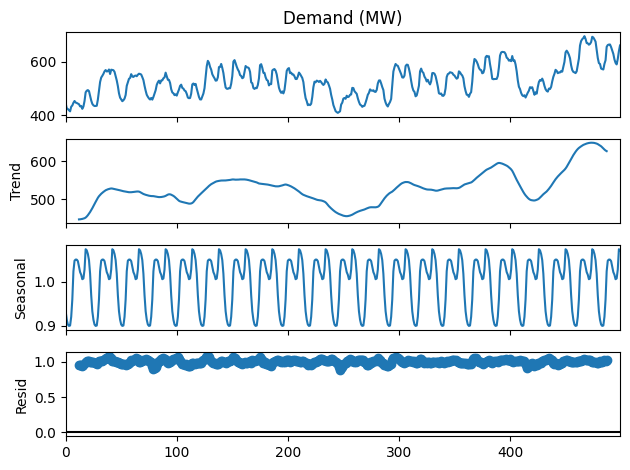

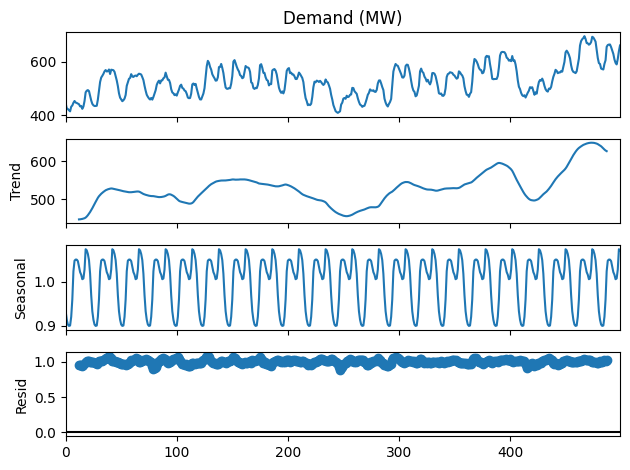

In [15]:
result = seasonal_decompose(X_tmp[:500], model="multiplicative", period=24)
result.plot()

### Hybrid Model Training

In [16]:
annual_fourier = CalendarFourier(freq="A", order=4) # 10 sin/cos pairs for annual seasonality
daily_fourier = CalendarFourier(freq="D", order=2) # 2 sin/cos pairs for daily fourier

dp = DeterministicProcess(
    index = train_data.index,
    constant = True,
    order = 5,
    seasonal = False,
    additional_terms = [annual_fourier, daily_fourier]
)

X = dp.in_sample()
X.head()

,const,trend,trend_squared,trend_cubed,trend**4,trend**5,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)"
datetime,,,,,,,,,,,,,,,,,,
2020-01-01 00:00,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000e+00
2020-01-01 01:00,1.0,2.0,4.0,8.0,16.0,32.0,0.000715,1.000000,0.001431,0.999999,0.002146,0.999998,0.002861,0.999996,0.258819,0.965926,0.500000,8.660254e-01
2020-01-01 02:00,1.0,3.0,9.0,27.0,81.0,243.0,0.001431,0.999999,0.002861,0.999996,0.004292,0.999991,0.005722,0.999984,0.500000,0.866025,0.866025,5.000000e-01
2020-01-01 03:00,1.0,4.0,16.0,64.0,256.0,1024.0,0.002146,0.999998,0.004292,0.999991,0.006438,0.999979,0.008583,0.999963,0.707107,0.707107,1.000000,6.123234e-17
2020-01-01 04:00,1.0,5.0,25.0,125.0,625.0,3125.0,0.002861,0.999996,0.005722,0.999984,0.008583,0.999963,0.011445,0.999935,0.866025,0.500000,0.866025,-5.000000e-01


In [17]:
X.columns

Index(['const', 'trend', 'trend_squared', 'trend_cubed', 'trend**4',
       'trend**5', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)',
       'sin(2,freq=A-DEC)', 'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)',
       'cos(3,freq=A-DEC)', 'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)',
       'sin(1,freq=D)', 'cos(1,freq=D)', 'sin(2,freq=D)', 'cos(2,freq=D)'],
      dtype='object')

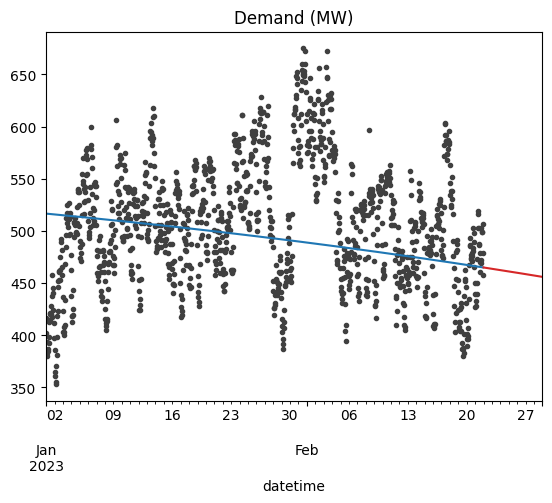

In [18]:
y = train_data["Demand (MW)"]
lr_model = LinearRegression(fit_intercept = True)
lr_model.fit(X, y)

y_pred_lr = pd.Series(lr_model.predict(X), index = y.index)
X_fore_lr = dp.out_of_sample(steps=168)
y_fore_lr = pd.Series(lr_model.predict(X_fore_lr), index = X_fore_lr.index)

ax = y["2023" : ].plot(color="0.25", style=".", title = "Demand (MW)")
ax = y_pred_lr["2023" : ].plot(ax = ax, label="seasonal")
ax = y_fore_lr["2023" : ].plot(ax=ax, label = "seasonal forecast", color="C3")
_ = ax.legend

In [19]:
mse = mean_squared_error(y_true=y, y_pred=y_pred_lr)
rmse = np.sqrt(mse)
print(f"mean squared error: {mse}")
print(f"root mean squared error: {rmse}")

mean squared error: 12685.626938314539
root mean squared error: 112.63048849363364


In [20]:
y_detrended = y - y_pred_lr
y_detrended.head()

datetime
2020-01-01 00:00   -68.037815
2020-01-01 01:00   -89.337824
2020-01-01 02:00   -90.337839
2020-01-01 03:00   -95.037859
2020-01-01 04:00   -99.037886
Freq: H, dtype: float64

In [21]:
from xgboost import XGBRegressor
xgb = XGBRegressor()
xgb_model = xgb.fit(X, y_detrended)

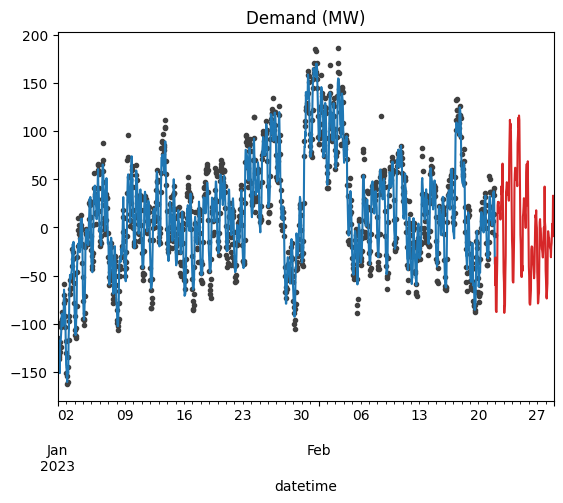

In [22]:
y_pred_xgb = pd.Series(xgb_model.predict(X), index = y.index)

X_fore_xgb = dp.out_of_sample(steps=168)
y_fore_xgb = pd.Series(xgb_model.predict(X_fore_xgb), index = X_fore_xgb.index)

ax = y_detrended["2023" : ].plot(color="0.25", style=".", title = "Demand (MW)")
ax = y_pred_xgb["2023" : ].plot(ax = ax, label="seasonal")
ax = y_fore_xgb["2023" : ].plot(ax=ax, label = "seasonal forecast", color="C3")
_ = ax.legend

In [23]:
mse = mean_squared_error(y_true=y_detrended, y_pred=y_pred_xgb)
rmse = np.sqrt(mse)
print(f"mean squared error: {mse}")
print(f"root mean squared error: {rmse}")

mean squared error: 374.2336091159959
root mean squared error: 19.345118482862695


### Final Inference

In [24]:
test_X = dp.out_of_sample(steps=168)
test_X.head()

,const,trend,trend_squared,trend_cubed,trend**4,trend**5,"sin(1,freq=A-DEC)","cos(1,freq=A-DEC)","sin(2,freq=A-DEC)","cos(2,freq=A-DEC)","sin(3,freq=A-DEC)","cos(3,freq=A-DEC)","sin(4,freq=A-DEC)","cos(4,freq=A-DEC)","sin(1,freq=D)","cos(1,freq=D)","sin(2,freq=D)","cos(2,freq=D)"
2023-02-22 00:00,1.0,27556.0,759333136.0,2.092418e+13,5.765868e+17,1.588843e+22,0.780296,0.625411,0.976011,-0.217723,0.440519,-0.897743,-0.425000,-0.905193,0.000000,1.000000,0.000000,1.000000e+00
2023-02-22 01:00,1.0,27557.0,759388249.0,2.092646e+13,5.766705e+17,1.589131e+22,0.780744,0.624851,0.975697,-0.219123,0.438586,-0.898689,-0.427596,-0.903970,0.258819,0.965926,0.500000,8.660254e-01
2023-02-22 02:00,1.0,27558.0,759443364.0,2.092874e+13,5.767542e+17,1.589419e+22,0.781192,0.624291,0.975382,-0.220523,0.436651,-0.899631,-0.430187,-0.902740,0.500000,0.866025,0.866025,5.000000e-01
2023-02-22 03:00,1.0,27559.0,759498481.0,2.093102e+13,5.768379e+17,1.589708e+22,0.781640,0.623730,0.975065,-0.221922,0.434714,-0.900568,-0.432776,-0.901502,0.707107,0.707107,1.000000,6.123234e-17
2023-02-22 04:00,1.0,27560.0,759553600.0,2.093330e+13,5.769217e+17,1.589996e+22,0.782087,0.623169,0.974745,-0.223320,0.432776,-0.901502,-0.435360,-0.900256,0.866025,0.500000,0.866025,-5.000000e-01


In [25]:
y_pred_lr = pd.Series(lr_model.predict(X), index = X.index)
y_pred_xgb = pd.Series(xgb_model.predict(X), index = X.index)
y_pred = y_pred_lr + y_pred_xgb

y_test_lr = pd.Series(lr_model.predict(test_X), index = test_X.index)
y_test_xgb = pd.Series(xgb_model.predict(test_X), index = test_X.index)

y_test = y_test_lr + y_test_xgb

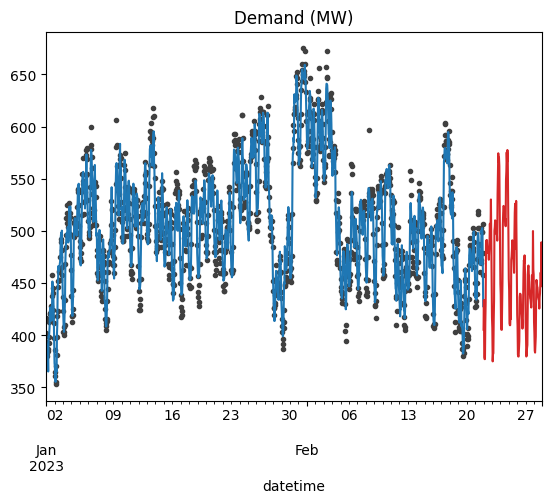

In [26]:
ax = y["2023" : ].plot(color="0.25", style=".", title = "Demand (MW)")
ax = y_pred["2023" : ].plot(ax = ax, label="seasonal")
ax = y_test["2023" : ].plot(ax=ax, label = "seasonal forecast", color="C3")
_ = ax.legend

In [27]:
mse = mean_squared_error(y_true=y, y_pred=y_pred)
rmse = np.sqrt(mse)
print(f"mean squared error: {mse}")
print(f"root mean squared error: {rmse}")

mean squared error: 374.2336091159959
root mean squared error: 19.345118482862695
